In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit
using Plots, LaTeXStrings
using DelimitedFiles
using DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
function print_fit_values(fit, par0, par_names, alpha=0.1)
    println(@sprintf "RSS = %.5f (convergence: %s)" sum(abs2, fit.resid) fit.converged)
    for i in 1:length(par0)
        name = par_names[i]
        val = fit.param[i]
        CIl = confidence_interval(fit, alpha)[i][1]
        CIr = confidence_interval(fit, alpha)[i][2]
        p0 = par0[i]
        println(@sprintf "  %s = %.3e (CI=(%.3e, %.3e), initial=%.3e)" name val CIl CIr p0)
    end
end

print_fit_values (generic function with 2 methods)

# Fitting the Virus Load Function to the Virus-Target Model

Here we investigate how the Virus Load function

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where 

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$,

fits to the standard viral kinetic ODE model 
$$
\begin{aligned}
\frac{dT}{dt} & = -\beta T V, \\
\frac{dI_1}{dt} & = \beta T V - k I_1, \\
\frac{dI_2}{dt} & = k I_1 - \frac{\delta I_2}{K + I_2}, \\
\frac{dV}{dt} & = p I_2 -c V.
\end{aligned}
$$
Since we are not fitting to data at this point, we do not use the empirical virus load function but the unmodified models.

In [4]:
function VirusLoadFunction(t, p)
    heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
    v₁(t, a₁, a₂, logVmax) = 1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
    v₂(t, a₂, α) = 1. - heaviside(t - a₂) + heaviside(t - a₂)*exp(-α*(t - a₂))
    v₃(t, b₁, b₂, logVmin) = 1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
    a₁, a₂, b₁, b₂, α, logVmin, logVmax = p
    log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
end

VirusLoadFunction (generic function with 1 method)

In [5]:
VirusTargetODE = @ode_def begin
    dT = -β*T*V
    dI₁ = β*T*V - k*I₁
    dI₂ = k*I₁ - δ*I₂/(K + I₂)
    dV = p*I₂ - c*V
end β k δ K p c
u0 = [1e+7, 75.0, 0.0, 1e-12]
tend = 9.0
tspan = (0.0, tend)
function VirusTargetModel(t, p)
    prob = ODEProblem(VirusTargetODE, u0, tspan, p)
    sol = solve(prob, Tsit5(), dtmax=1e-2)
    log10.(sol(t)[end, :])
end

VirusTargetModel (generic function with 1 method)

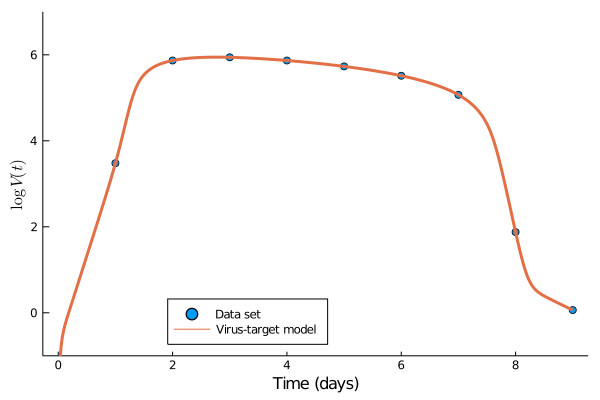

In [6]:
ttdata = Vector(range(0., tend, step=1.))
parsVTM = (β = 2.629e-04,
           k = 1.480e+00,
           δ = 1.593e+06,
           K = 7.899e+04,
           p = 2.090e+00,
           c = 1.505e+01)
vvdata = VirusTargetModel(ttdata, parsVTM)
pt = plot(ttdata, vvdata, 
    label="Data set", seriestype=:scatter)
tt = Vector(range(0., tend, step=1e-2))
plot!(pt, tt, VirusTargetModel(tt, parsVTM), lw=3,
    label="Virus-target model", 
    grid=:off, legend=:bottom,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)

Now, let fit the Virus load function to the virus-target model.

In [7]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmin, logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, -6.0,    5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, -7.0,    4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, -2.0,    7.0]
fit = curve_fit(VirusLoadFunction, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.9745451850777035, 2.7506592719368705, 6.193954646936081, 7.761808943906898, 0.32722402408372825, -5.07071165922618, 6.011828927203168], [12.0, 1.3213022080016401e-5, -8.973103960485673e-5, 0.034749427628471, -0.032911524223343314, -0.03821160341298491, 0.036505287208087545, -7.555765651190427e-5, 2.0937056243175434e-5, -4.4423364350953953e-7], [0.0 0.0 … 0.0 0.0; -2.880795529697054 -0.0438446181264822 … 0.0 0.9996691642278182; … ; 1.5564983693687127e-5 0.14210607340514245 … 0.020781634674534366 0.9999999999950604; 1.5564981401904088e-5 0.14210607340472586 … 0.9781419503912422 0.9999999999954416], true, Float64[])

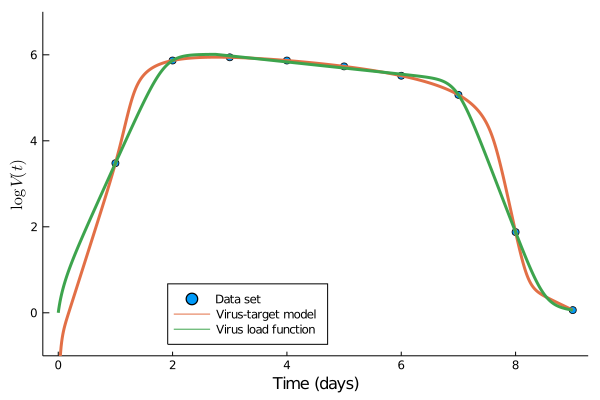

In [8]:
tt = Vector(range(0., tend, step=1e-2))
pt = plot(ttdata, vvdata, 
    label="Data set", seriestype=:scatter)
plot!(pt, tt, VirusTargetModel(tt, parsVTM), lw=3,
    label="Virus-target model")
plot!(pt, tt, VirusLoadFunction(tt, fit.param), lw=3,
    label="Virus load function", 
    grid=:off, legend=:bottom,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)

In [9]:
par_names = ["a₁", "a₂", "b₁", "b₂", "α", "logVmin", "logVmax"]
print_fit_values(fit, par0, par_names)

RSS = 144.00508 (convergence: true)
  a₁ = 9.745e-01 (CI=(-6.251e+00, 8.200e+00), initial=7.000e-01)
  a₂ = 2.751e+00 (CI=(-3.257e+01, 3.807e+01), initial=2.880e+00)
  b₁ = 6.194e+00 (CI=(-1.549e+01, 2.787e+01), initial=6.000e+00)
  b₂ = 7.762e+00 (CI=(-2.029e+00, 1.755e+01), initial=7.600e+00)
  α = 3.272e-01 (CI=(-1.650e+01, 1.715e+01), initial=2.000e-01)
  logVmin = -5.071e+00 (CI=(-4.319e+01, 3.305e+01), initial=-6.000e+00)
  logVmax = 6.012e+00 (CI=(-6.606e+00, 1.863e+01), initial=5.000e+00)


Using more data points to see how the the virus load function fits overall.

In [10]:
tend = 9.0
ttdata = Vector(range(0., tend, step=0.1))
vvdata = VirusTargetModel(ttdata, parsVTM)
#       a₁,   a₂,   b₁,   b₂,   α,    logVmin, logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, -6.0,   5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, -7.0,    4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, -2.0,    7.0]
fit = curve_fit(VirusLoadFunction, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.98298125874652, 2.130951150154165, 6.793693082373001, 7.870906362740954, 0.35119320554227157, -4.838195832330288, 6.050847214041973], [12.0, 0.4478550852839382, 0.15146129478581224, 0.0029147265683980295, -0.050746730607830526, -0.05106179573046954, -0.028830403752100997, 0.0006230307821164516, 0.02912405336985291, 0.048175272151791404  …  0.14369804818416854, 0.14397744176436822, 0.04682565031869568, -0.052143730903724816, -0.08777951770580295, -0.07419507212737039, -0.03805223105565089, 0.006546642306069578, 0.054086492027251326, 0.10262037142378423], [0.0 0.0 … 0.0 0.0; -1.1765385380948878 0.4932749946861736 … 0.0 0.1505064354364768; … ; 7.200965651379525e-7 0.1525209390750817 … 0.9982097930171762 0.9999999999930216; 7.200896897888353e-7 0.1525209390718553 … 0.9994116858073792 0.9999999999934003], true, Float64[])

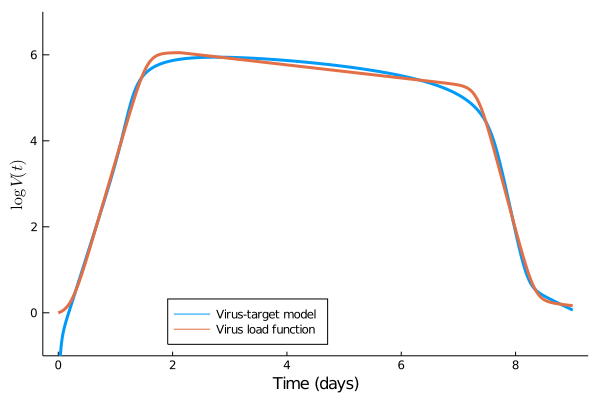

In [11]:
tt = Vector(range(0., tend, step=1e-2))
pt = plot(tt, VirusTargetModel(tt, parsVTM), lw=3,
    label="Virus-target model")
plot!(pt, tt, VirusLoadFunction(tt, fit.param), lw=3,
    label="Virus load function", 
    grid=:off, legend=:bottom,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
savefig(figdir*"VLFVTMComparisson.png")
savefig(figdir*"VLFVTMComparisson.pdf")
display(pt)

The data fit is very accurate but the two functions differ in shape near the shoulders and the slope in the portion of slow decay.

In [12]:
print_fit_values(fit, par0, par_names)

RSS = 145.38568 (convergence: true)
  a₁ = 9.830e-01 (CI=(7.941e-01, 1.172e+00), initial=7.000e-01)
  a₂ = 2.131e+00 (CI=(1.598e+00, 2.664e+00), initial=2.880e+00)
  b₁ = 6.794e+00 (CI=(6.115e+00, 7.473e+00), initial=6.000e+00)
  b₂ = 7.871e+00 (CI=(7.647e+00, 8.094e+00), initial=7.600e+00)
  α = 3.512e-01 (CI=(-8.749e-02, 7.899e-01), initial=2.000e-01)
  logVmin = -4.838e+00 (CI=(-6.107e+00, -3.570e+00), initial=-6.000e+00)
  logVmax = 6.051e+00 (CI=(5.539e+00, 6.563e+00), initial=5.000e+00)


As expected some of the values change if we include more data points.

**The virus load function fits very well to the viral target model in the middle portion, they only differ in the shape of the shoulders, the VLF is more rectangular than the VTM. However, they differ siginificantly in the tails, the VLF is more flat in the tails.**